# Stack Overflow - Clustering

This notebook continues exploring the the data of the GADS23 Kaggle Stack Overflow competition.

Your goal was to build a classifier that predicts whether or not a question will be closed given the question as submitted.

Let's see if clustering would be helpful

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("/Users/ruben/Downloads/train.csv", index_col=0)

### Tags
One obvious candidate for clustering would be the vast amount of tags we have.

In [3]:
%%time
data['tags'] = data.apply(lambda x: " ".join(set(str(x['Tag%d' % i]) for i in xrange(1, 6))), axis=1)
data['tags'] = data['tags'].str.replace('nan', '').str.replace("  ", " ").str.strip()

CPU times: user 5.24 s, sys: 49.4 ms, total: 5.29 s
Wall time: 5.28 s


In [4]:
tags = set([tag for tags in data.tags.values for tag in tags.split()])
print "We have", len(tags), "tags."

We have 18309 tags.


That is a lot. We could maybe cluster these, and then feed the cluster category into the model, rather than an ID for one of the 18K tags.  We could use `CountVectorizer` for this again.

In [5]:
n_clusters = 10
# N = 10000  # only use the first N documents for clustering (to speed up computations)
# data = data.iloc[:N]

In [6]:
%%time
cv = CountVectorizer(stop_words='english', ngram_range=(1, 1), max_features=5000, min_df=10, max_df=.95, binary=True)
X = cv.fit_transform(data.tags)

CPU times: user 950 ms, sys: 16.5 ms, total: 966 ms
Wall time: 962 ms


#### Clustering tags by their documents

In [7]:
XT = X.T
XT = StandardScaler().fit_transform(XT.toarray().astype(float))

In [8]:
%%time
model = KMeans(n_clusters=n_clusters)
model.fit(XT)

CPU times: user 4min 34s, sys: 13.2 s, total: 4min 48s
Wall time: 1min 53s


In [9]:
np.unique(model.predict(XT), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([   1, 3224,    2,    1,    1,    1,    1,    1,    2,    1]))

Hmm, that didn't quite work: almost all tags got into one cluster, and the other clusters just got one tag. (Note we have less tags since we only used part of the data.)

#### Clustering documents by their tags

One other way we could do, is clustering the documents according to their tags, and then use their document cluster to feed into the model.

In [10]:
%%time
model.fit(X)

CPU times: user 35.5 s, sys: 90.5 ms, total: 35.5 s
Wall time: 35.6 s


KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [11]:
np.unique(model.predict(X), return_counts=True)

/Users/ruben/anaconda/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:862: RuntimeWarning: Got data type int64, converted to float to avoid overflows
  X = self._check_test_data(X)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([12219, 79839,  7798,  4213,  2353,  3632, 10093,  2864,  5398, 11863]))

Much better! Let's inspect the most common tags in these clusters.

In [12]:
top = 12
print "Top %d tags per cluster:" % top
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = cv.get_feature_names()
for i in range(n_clusters):
    print "Cluster %d:" % i,
    for ind in order_centroids[i, :top]:
        print terms[ind],
    print

Top 12 tags per cluster:
Cluster 0: php mysql html javascript php5 jquery arrays ajax wordpress codeigniter database sql
Cluster 1: android python jquery html css mysql google visual ios facebook web objective
Cluster 2: javascript jquery html css ajax php html5 google js events internet json
Cluster 3: sql server 2008 database mysql net 2005 tsql query linq asp oracle
Cluster 4: linux ubuntu kernel unix bash shell php java command python networking ssh
Cluster 5: ruby rails activerecord python jquery heroku php mysql rubygems rspec ajax javascript
Cluster 6: net asp mvc vb visual jquery studio javascript web ajax framework entity
Cluster 7: windows phone net xp server visual linux 2008 silverlight services java mobile
Cluster 8: iphone objective ios xcode ipad sdk cocoa touch ios5 uitableview core app
Cluster 9: java android ee eclipse swing web spring xml hibernate php jsp javascript


Seems like there are at least a front-end cluster, a database cluster, and a mobile cluster.  Note that, since we clustered documents, not tags, a tag might be associated with several clusters.

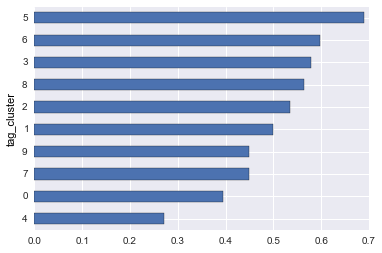

In [13]:
data['tag_cluster'] = model.predict(X)
s = data.groupby('tag_cluster').OpenStatus.mean().sort(inplace=False)
f = s.plot(kind='barh')

The difference in closed posts per cluster suggests we could try extracting some value from this.  We leave it as an exercise to verify if adding these clusters to your feature matrix indeed leads to a higher preduction accuracy.

#### Jaccard distance

The [_Jaccard index_](https://en.wikipedia.org/wiki/Jaccard_index) is a similarity metric between text documents. It measures how many words two documents have in common, as a fraction of the total number of distinct words in both documents.

$$\text{Jaccard index} = \frac{ |A \cap B | }{ |A \cup B| }$$

We could make a Jaccard matrix $J$, with pairwise similarities $J_{ij}$ as entries.
- `J[i, j]` = Jaccard similarity between doc _i_ and _j_ (between 0 and 1)
- `J[i, i]` = 1, obviously, and
- `J[i, j]` = `J[i, j]`, i.e., the matrix is symmetric.

We could also define the _Jaccard distance_, which has $D_{ii} = 0$ for identical documents, and bigger values as the documents have less words in common.  We define: $D = 1 - J,$ which has values between 0 and 1.

We could also use this for comparing our tags: how many documents do two tages have in common?

In [14]:
%%time
cv = CountVectorizer(stop_words='english', ngram_range=(1, 1), max_features=5000,
                     min_df=10, max_df=.95, binary=True)  # binary=True is important!
X = cv.fit_transform(data.tags)

CPU times: user 911 ms, sys: 18.8 ms, total: 930 ms
Wall time: 922 ms


Compute the Jaccard matrix and the distance matrix.

Note that we could compute

    U = [[n_docs[i] + n_docs[j] - I[i, j] for i in xrange(n_tags)] 
         for j in xrange(n_tags)]  # this is slow

but that is very slow. We use `numpy`'s vectorization and broadcasting instead.

In [15]:
n_tags = X.shape[1]  # number of tags
I = X.T.dot(X).toarray()  # X-transposed times X gives a tag x tag matrix with the # of docs in common
n_docs = np.diag(I)  # number of docs per tag
N = n_docs.reshape(n_tags, 1) * np.ones(n_tags)  # number of docs broadcasted over the entire row
U = N + N.T - I  # total distinct docs = n_docs_i + n_docs_j - words in common
J = I / U.astype(float)
D = 1 - J

Let's pick a few random tags and see what the closest tags are.

In [16]:
top = 10
tags = np.array(cv.get_feature_names())
for no in np.random.choice(n_tags, top, replace=False):  # pick 10 random tags
    print "%-18s:" % tags[no], " ".join(tags[D[no].argsort()[:top]])

paste             : paste copy cut clipboard pdt filepath filenames neo4j contextmenu vi
subclass          : subclass nib uilabel nsoperation covariance nsview extends nstableview pointer generic
tail              : tail recursion finite factorial best ocaml state append distribution logging
thrift            : thrift buffers protocol asio rpc weblogic cassandra agile compatibility boost
fragment          : fragment identifier changes orientation mapview honeycomb adapter osgi escaping state
launch            : launch condition installshield manifest orientation components purchase exe timeout device
fiddler           : fiddler firebug localhost playframework https proxy cookies firefox session post
arm               : arm embedded vlc microcontroller cpu floating x86 pi avr nfs
ajax              : ajax jquery javascript json asp php mvc net html forms
entitymanager     : entitymanager jpa ejb nullpointerexception hibernate generics netbeans entity spring java


Makes sense. Some tags have more meaning than others, I expect. Note that this is not a partitioning, as we only have a distance between words.

We could also apply `KMeans` to this Jaccard matrix, as the entries are indeed distances.

In [17]:
model.fit(D)
print "Top %d tags per cluster:" % top
order_centroids = model.cluster_centers_.argsort()
for i in range(n_clusters):
    print "Cluster %d:" % i, " ".join(tags[order_centroids[i, :top]])

Top 10 tags per cluster:
Cluster 0: objective iphone ios cocoa touch xcode memory ipad ios5 leaks
Cluster 1: studio visual 2010 castle source windsor protocol buffers setter getter
Cluster 2: internet machine js explorer computer intelligence questions interview coding mod
Cluster 3: processing gd image manipulation parallel transparency bit png imagemagick alpha
Cluster 4: exc bad array multidimensional access casting overloading interface type operator
Cluster 5: cream sandwich ice honeycomb softkeyboard decompiling launcher spinner htc fullscreen
Cluster 6: command ruby line amazon programming rails bash scripting shell languages
Cluster 7: asp net binding dependency wpf mvc mvvm injection data xaml
Cluster 8: latitude longitude area gprs distance circle spatial polygon mapkit coordinates
Cluster 9: intellij idea server sql google tips tricks engine dynamics crm


That looks quite promising.

Unfortunately, the model has put a lot of tags into the same cluster again:

In [18]:
np.unique(model.predict(D), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([  37,   92, 2669,   35,   84,    3,  176,   28,    2,  109]))

<hr>
## Exercise
- Add the cluster information to your feature set and train a model on your data. Does the inclusion of these clusters indeed imporve prediction accuracy?  (Don't forget to cross-validate.)
- Try different values for `n_clusters` and see if you could find a good value using the _elbow method_.
- We have looked at clustering tags by documents, clustering documents by tags, and at the Jaccard distance between two tags using the number of documents they have in common.  Could you think of other ways of clustering tags or documents?  Try to implement these and see how effective they are.